In [1]:
import sys
sys.path.append('C:\\Users\\smorn\\Python\\')
#change to whatever path is needed to get to utils.py
import utils

import netCDF4
import numpy as np
from numpy.fft import fft, ifft
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.dates as mpldts
from scipy.stats import binned_statistic
import datetime# as dt
import urllib
import time
import calendar
import csv

In [2]:
# stn = '200' #154
# dataset = 'archive' # Enter 'archive' or 'realtime'
# deploy = '8' # If archive dataset, set deployment number from .nc file  #12

# start_date = '12/23/2020 9:00'#'06/20/2023 9:00' # MM/DD/YYYY HH:MM
# duration  = 30 # Set length of timeseries (minutes) #30

stn = '154' #154
dataset = 'archive' # Enter 'archive' or 'realtime'
deploy = '12' # If archive dataset, set deployment number from .nc file  #12

start_date = '06/20/2023 9:00' # MM/DD/YYYY HH:MM
duration  = 30 # Set length of timeseries (minutes) #30

qc_level = 2 # Filter data with qc flags above this number

# Archive
data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/' + stn + 'p1/' + stn + 'p1_d' + deploy + '.nc'
# Realtime
if dataset == 'realtime':
    data_url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/' + stn + 'p1_xy.nc'


nc = netCDF4.Dataset(data_url)
#nc = netCDF4.Dataset('https://thredds.cdip.ucsd.edu/thredds/ncss/point/cdip/archive/160p1/160p1_d08.nc')
# Turn off auto masking
nc.set_auto_mask(False)
#nc
#data_url

In [3]:
xdisp = nc.variables['xyzXDisplacement'] # Make a numpy array of three directional displacement variables (x, y, z)
ydisp = nc.variables['xyzYDisplacement']
zdisp = nc.variables['xyzZDisplacement']
qc_flag = nc.variables['xyzFlagPrimary']
filter_delay = nc.variables['xyzFilterDelay']
start_time = nc.variables['xyzStartTime'][:] # Variable that gives start time for buoy data collection
sample_rate = nc.variables['xyzSampleRate'][:] # Variable that gives rate (frequency, Hz) of sampling
end_time = start_time + (len(xdisp)/sample_rate) # Calulate end time for buoy data collection


Fq_cdip = np.asarray(nc.variables['waveFrequency'])
Ed_cdip = np.asarray(nc.variables['waveEnergyDensity'])
waveTime = nc.variables['waveTime'][:]
Dmean_cdip = nc.variables['waveMeanDirection']

    
# Check start and end dates of deployment
data_start = utils.get_human_timestamp(start_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
data_end = utils.get_human_timestamp(end_time - filter_delay[0],"%m/%d/%Y %H:%M:%S")
print("data_start: " + data_start)
print("  data_end: " + data_end)

# Find UNIX timestamps for user human-formatted start/end dates
unix_start = utils.get_unix_timestamp(start_date,"%m/%d/%Y %H:%M") 
unix_end = unix_start + (duration * 60) # Create UNIX end stamp by adding duration to 'unix_start'

nearest_start = utils.find_nearest(waveTime, unix_start)  # Find the closest unix timestamp
nearest_index = np.where(waveTime==nearest_start)[0][0]  # Grab the index number of found date

# Create specialized array using UNIX Start and End times minus Filter Delay, and Sampling Period (1/sample_rate) 
# to calculate sub-second time values that correspond to Z-Displacement sampling values
sample_time = np.arange((start_time - filter_delay[0]), end_time - filter_delay[0],(1/(sample_rate)))

# Find corresponding start/end date index numbers in 'sample_time' array    
start_index = sample_time.searchsorted(unix_start) 
end_index = sample_time.searchsorted(unix_end)


sample_time_cut = sample_time[start_index:end_index]
sample_time_cut *= 1000
t = sample_time_cut.astype('datetime64[ms]').astype(datetime.datetime)

data_start: 11/03/2022 14:57:46
  data_end: 10/28/2024 16:57:46


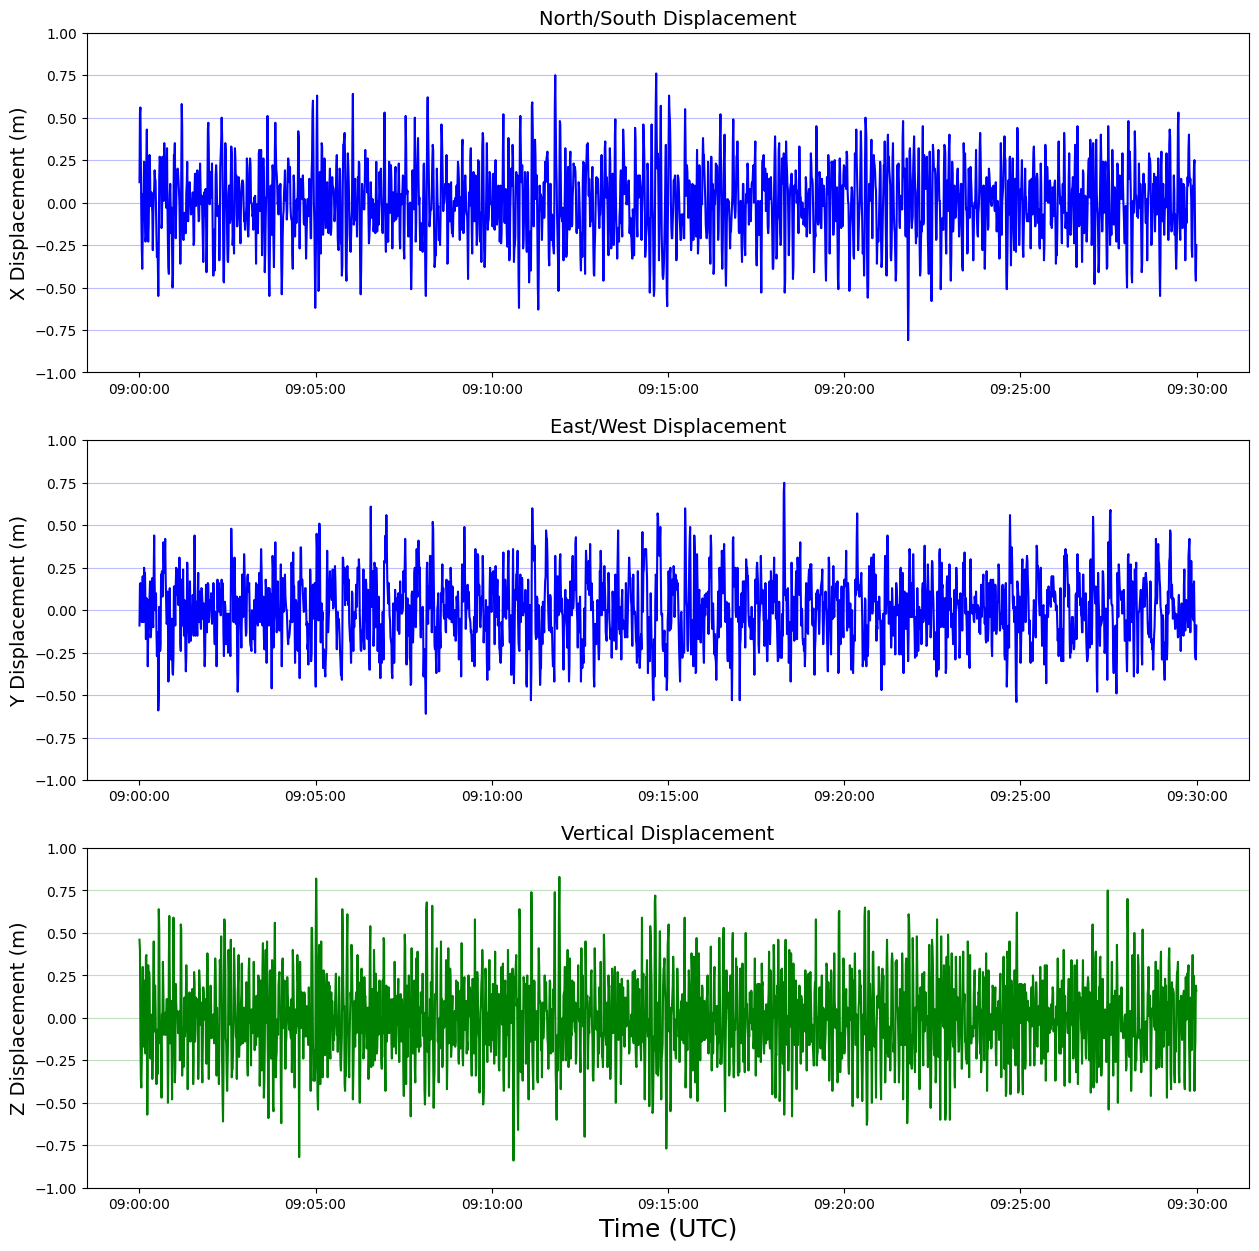

In [6]:
# Limit data to date/times
x = xdisp[start_index:end_index]
y = ydisp[start_index:end_index]
z = zdisp[start_index:end_index]
qc = qc_flag[start_index:end_index]

# Filter out by quality control level
x = np.ma.masked_where(qc>qc_level,x)
y = np.ma.masked_where(qc>qc_level,y)
z = np.ma.masked_where(qc>qc_level,z)

#dt = np.mean(np.diff(t))
dt = 0.78125

# Specify figure size
fig = plt.figure(figsize=(15,15))

# Create 3 stacked subplots for three Directional Displacement Parameters (xyz)
plt_x = plt.subplot(3,1,1)
plt_x.plot(t,x,'b')
plt_y = plt.subplot(3,1,2, sharex=plt_x)
plt_y.plot(t,y,'b')
plt_z = plt.subplot(3,1,3, sharex=plt_x)
plt_z.plot(t,z,'g')

# Set titles
#plt.suptitle(station_title + "\n" + "Time: " + start_date, fontsize=22, y=0.97)

# Set x-axis tick format to "HH:MM:SS" and tick interval to every 5 minutes
#days = mpldts.MinuteLocator(interval=5) 
daysFmt = mpldts.DateFormatter('%H:%M:%S')
#plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(daysFmt)

ymin=np.floor(min(min(x), min(y), min(z)))
ymax=np.ceil(max(max(x), max(y), max(z)))

# Set y-axis limits for each plot
plt_x.set_ylim(ymin,ymax)
plt_y.set_ylim(ymin,ymax)
plt_z.set_ylim(ymin,ymax)

# Label each subplot title
plt_x.set_title('North/South Displacement', fontsize=14)
plt_y.set_title('East/West Displacement', fontsize=14)
plt_z.set_title('Vertical Displacement', fontsize=14,y=1)

# Label each y-axis
plt_x.set_ylabel('X Displacement (m)', fontsize=14)
plt_y.set_ylabel('Y Displacement (m)', fontsize=14)
plt_z.set_ylabel('Z Displacement (m)', fontsize=14)

# Label x-axis
plt.xlabel('Time (UTC)', fontsize=18)

# Plot dashed gridlines
plt_x.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_y.grid(axis='y', which='major', color='b', linestyle='-', alpha=0.25)
plt_z.grid(axis='y', which='major', color='g', linestyle='-', alpha=0.25)

In [7]:
[PSD_z,wsc,a1,b1,a2,b2] = utils.fourier_calculations(x,y,z,dt)

C:\Users\smorn\Python\utils.py:281: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


7.600094814380095 is the max value of energy density


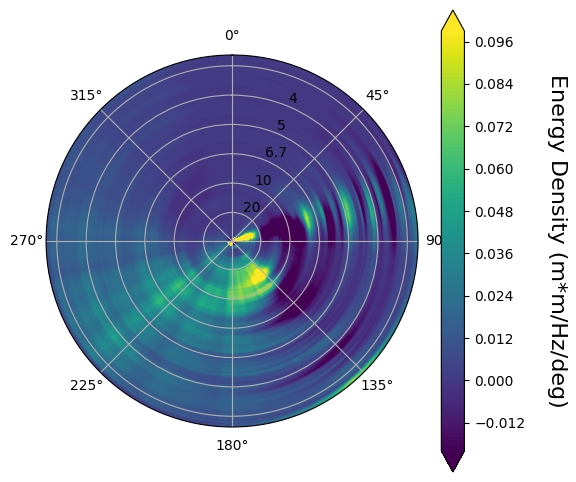

In [8]:
utils.plot_spec(PSD_z,wsc,a1,b1,a2,b2)